In [1]:
import pandas as pd
import numpy as np
from utils import reduce_memory_usage
from utils import break_datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_percentage_error,mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import joblib
import zipfile
import os
import category_encoders
from sklearn.preprocessing import StandardScaler
import joblib
import zipfile
import os
import holidays

warnings.filterwarnings('ignore')

# Specify the ZIP file name
zip_filename = "../dataset/filtered.zip"

# Extract the model file from the ZIP archive
with zipfile.ZipFile(zip_filename, "r") as archive:
    # Extract the model file (named "your_model.pkl" in this example)
    archive.extract("filtered.pkl")
    
# Load the model
df = joblib.load("filtered.pkl")  # Replace with "pickle.load" if you used pickle

os.remove("filtered.pkl")

In [2]:
def percent_missing_val(df):

  percent_missing = (df.isnull().sum() * 100) / len(df)
  missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
  return missing_value_df

def nan_fillers(df):
  air_temp_df=df.groupby(['site_id', 'dayofweek', 'weekofyear'])['air_temperature'].transform('mean')
  df['air_temperature'].fillna(air_temp_df, inplace=True)

  dew_temp_df=df.groupby(['site_id', 'dayofweek', 'weekofyear'])['dew_temperature'].transform('mean')
  df['dew_temperature'].fillna(dew_temp_df, inplace=True)

  cloud_df=df.groupby(['site_id', 'dayofweek', 'weekofyear'])['cloud_coverage'].transform('mean')
  df['cloud_coverage'].fillna(cloud_df, inplace=True)

  sea_level_df=df.groupby(['site_id', 'dayofweek', 'weekofyear'])['sea_level_pressure'].transform('mean')
  df['sea_level_pressure'].fillna(sea_level_df, inplace=True)

  precip_df=df.groupby(['site_id', 'dayofweek', 'weekofyear'])['precip_depth_1_hr'].transform('mean')
  df['precip_depth_1_hr'].fillna(precip_df, inplace=True)

  wind_dir_df=df.groupby(['site_id', 'dayofweek', 'weekofyear'])['wind_direction'].transform('mean')
  df['wind_direction'].fillna(wind_dir_df, inplace=True)

  wind_speed_df=df.groupby(['site_id', 'dayofweek', 'weekofyear'])['wind_speed'].transform('mean')
  df['wind_speed'].fillna(wind_speed_df, inplace=True)


  return df

def circular_encode(feature, max_value):
    sin_encoded = np.sin(2 * np.pi * feature / max_value)
    cos_encoded = np.cos(2 * np.pi * feature / max_value)
    return sin_encoded, cos_encoded

In [3]:
df = df[df['site_id'].isin([1, 6])]
df['log_meter_reading']=np.log1p(df['meter_reading'])
df['log_square_feet']=np.log1p(df['square_feet'])
df= break_datetime(df)
df.drop(['year_built', 'floor_count'], axis=1,inplace=True)
df= nan_fillers(df)
df['cloud_coverage'].fillna(df['cloud_coverage'].median(), inplace=True)
df['sea_level_pressure'].fillna(df['sea_level_pressure'].median(), inplace=True)
df['precip_depth_1_hr'].fillna(df['precip_depth_1_hr'].median(), inplace=True)
df=df.sort_values(by='timestamp')
df['month_sin'], df['month_cos'] = circular_encode(df['month'], 12)
df['hour_sin'], df['hour_cos'] = circular_encode(df['hour'], 24)
df['dayofweek_sin'], df['dayofweek_cos'] = circular_encode(df['dayofweek'], 7)
label_enc= LabelEncoder()
label_enc.fit(df['primary_use'])
df['primary_use_encoded'] = label_enc.transform(df['primary_use'])
df['is_weekday']=df['dayofweek'] <= 5

In [4]:
df = df[["timestamp","site_id","building_id", "log_meter_reading"]]
df

,timestamp,site_id,building_id,log_meter_reading
3,2016-01-01 00:00:00,1,105,3.190624
638,2016-01-01 00:00:00,6,761,0.920601
637,2016-01-01 00:00:00,6,760,4.257267
636,2016-01-01 00:00:00,6,759,2.772589
635,2016-01-01 00:00:00,6,758,3.645014
...,...,...,...,...
11529477,2016-12-31 23:00:00,1,129,4.297285
11529476,2016-12-31 23:00:00,1,128,4.310799
11529475,2016-12-31 23:00:00,1,127,2.924505
11529495,2016-12-31 23:00:00,1,147,4.785406


In [12]:
df = df.groupby(['site_id', 'timestamp'])['log_meter_reading'].mean().reset_index()

In [13]:
df

,site_id,timestamp,log_meter_reading
0,1,2016-01-01 00:00:00,3.604061
1,1,2016-01-01 01:00:00,4.260025
2,1,2016-01-01 02:00:00,4.254992
3,1,2016-01-01 03:00:00,4.244707
4,1,2016-01-01 04:00:00,4.231702
...,...,...,...
17562,6,2016-12-31 19:00:00,4.391754
17563,6,2016-12-31 20:00:00,4.365319
17564,6,2016-12-31 21:00:00,4.354705
17565,6,2016-12-31 22:00:00,4.349384


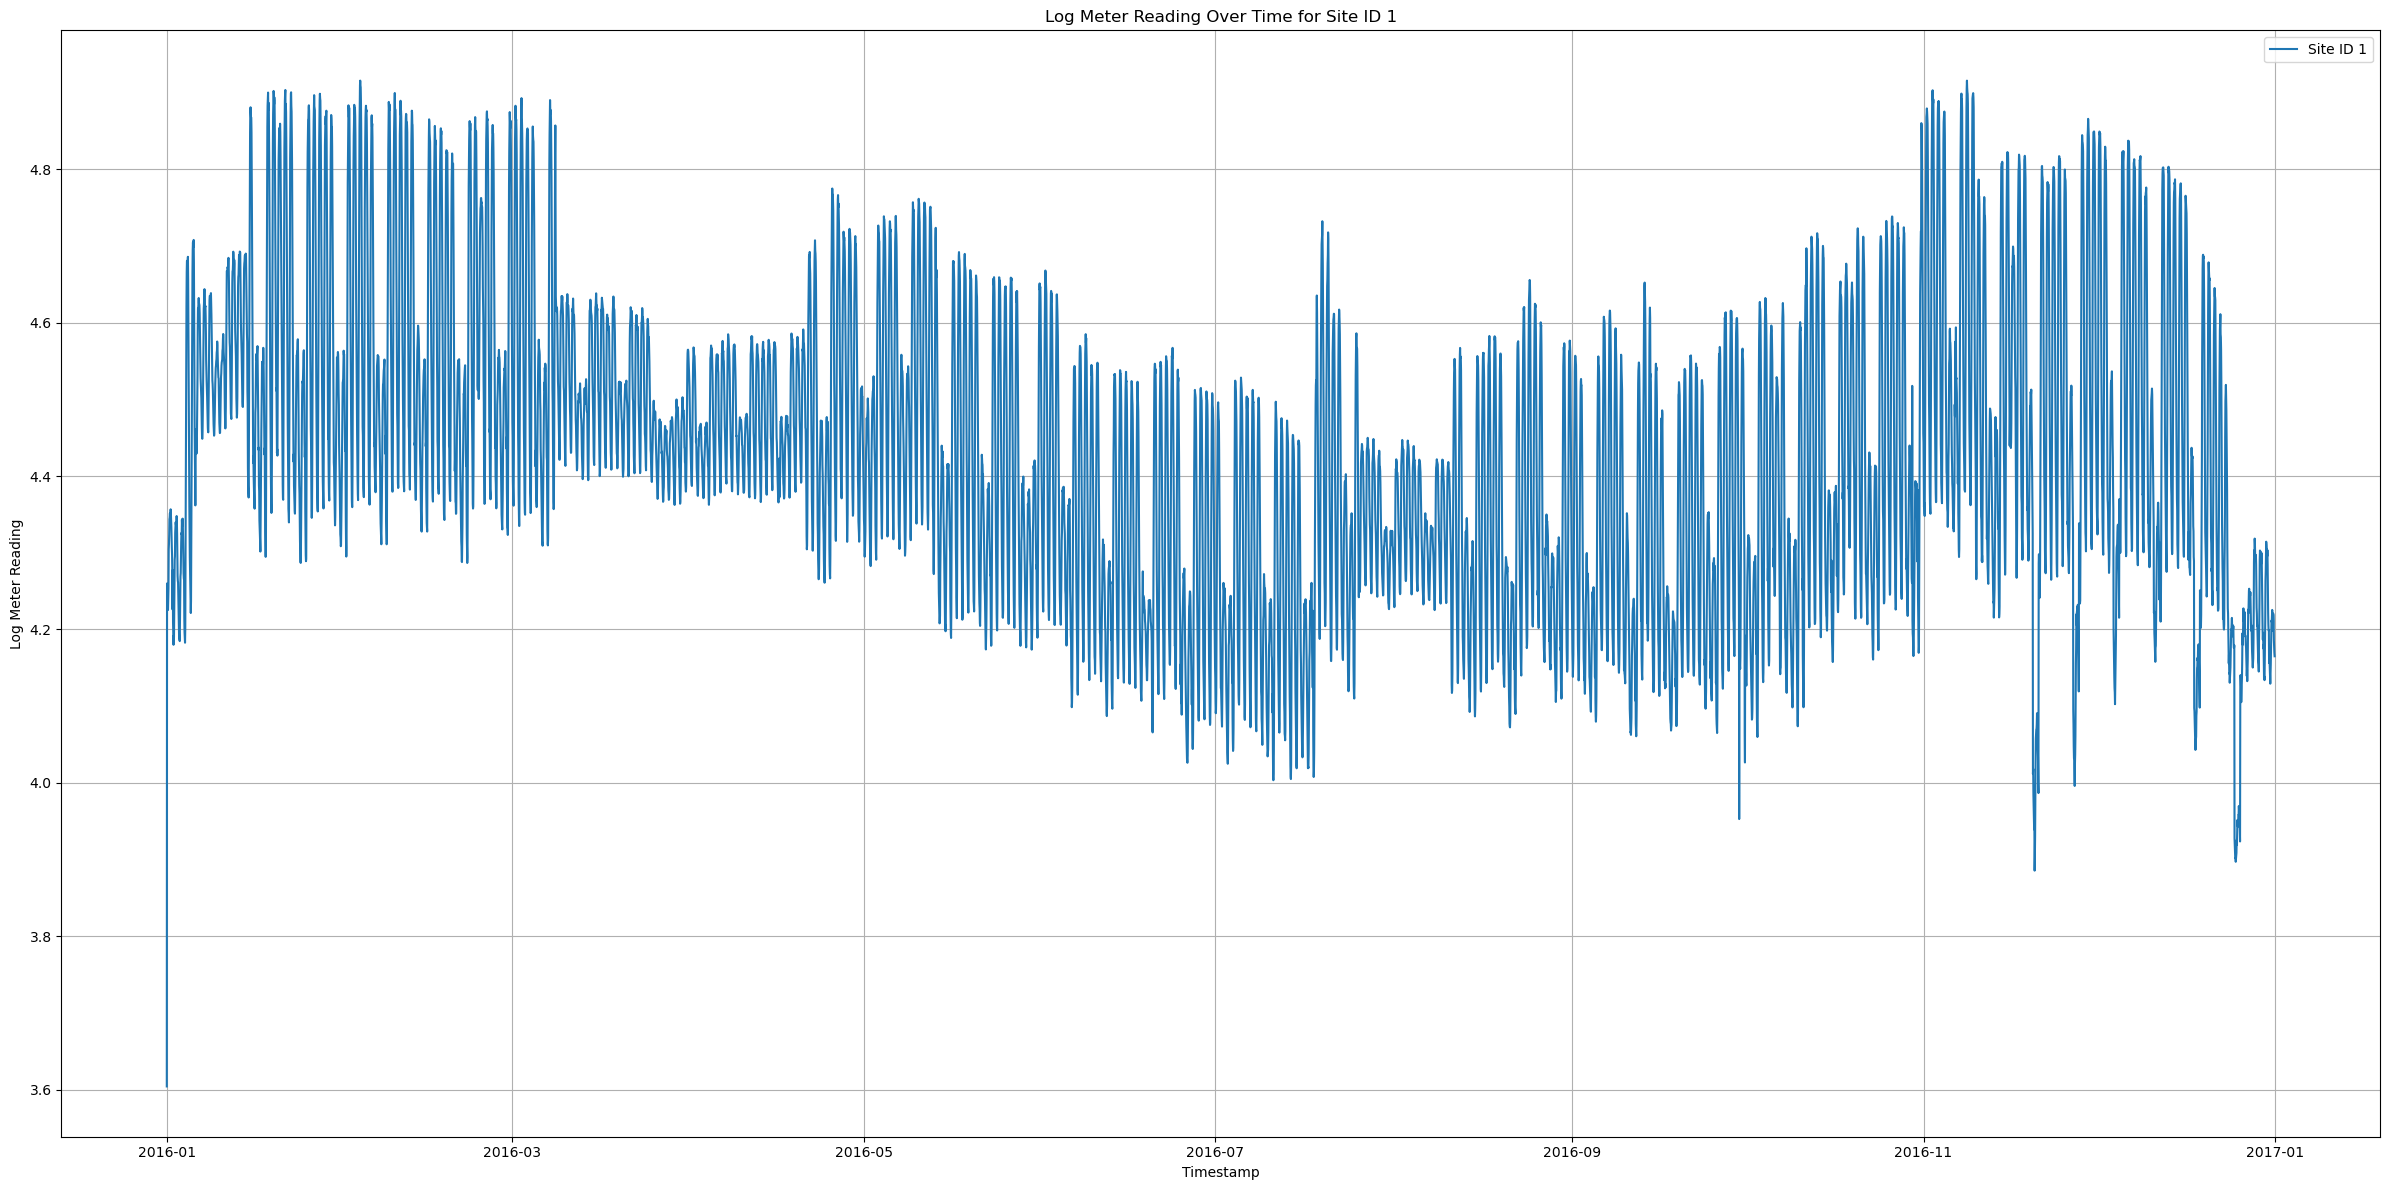

In [14]:
site_1 = df[df['site_id'] == 1]  # Changed variable name to site_1
plt.figure(figsize=(24, 12))  # Adjust the figure size as needed
plt.plot(site_1['timestamp'], site_1['log_meter_reading'], label='Site ID 1')  # Updated variable name

# Customize the plot
plt.title('Log Meter Reading Over Time for Site ID 1')
plt.xlabel('Timestamp')
plt.ylabel('Log Meter Reading')
plt.grid(True)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

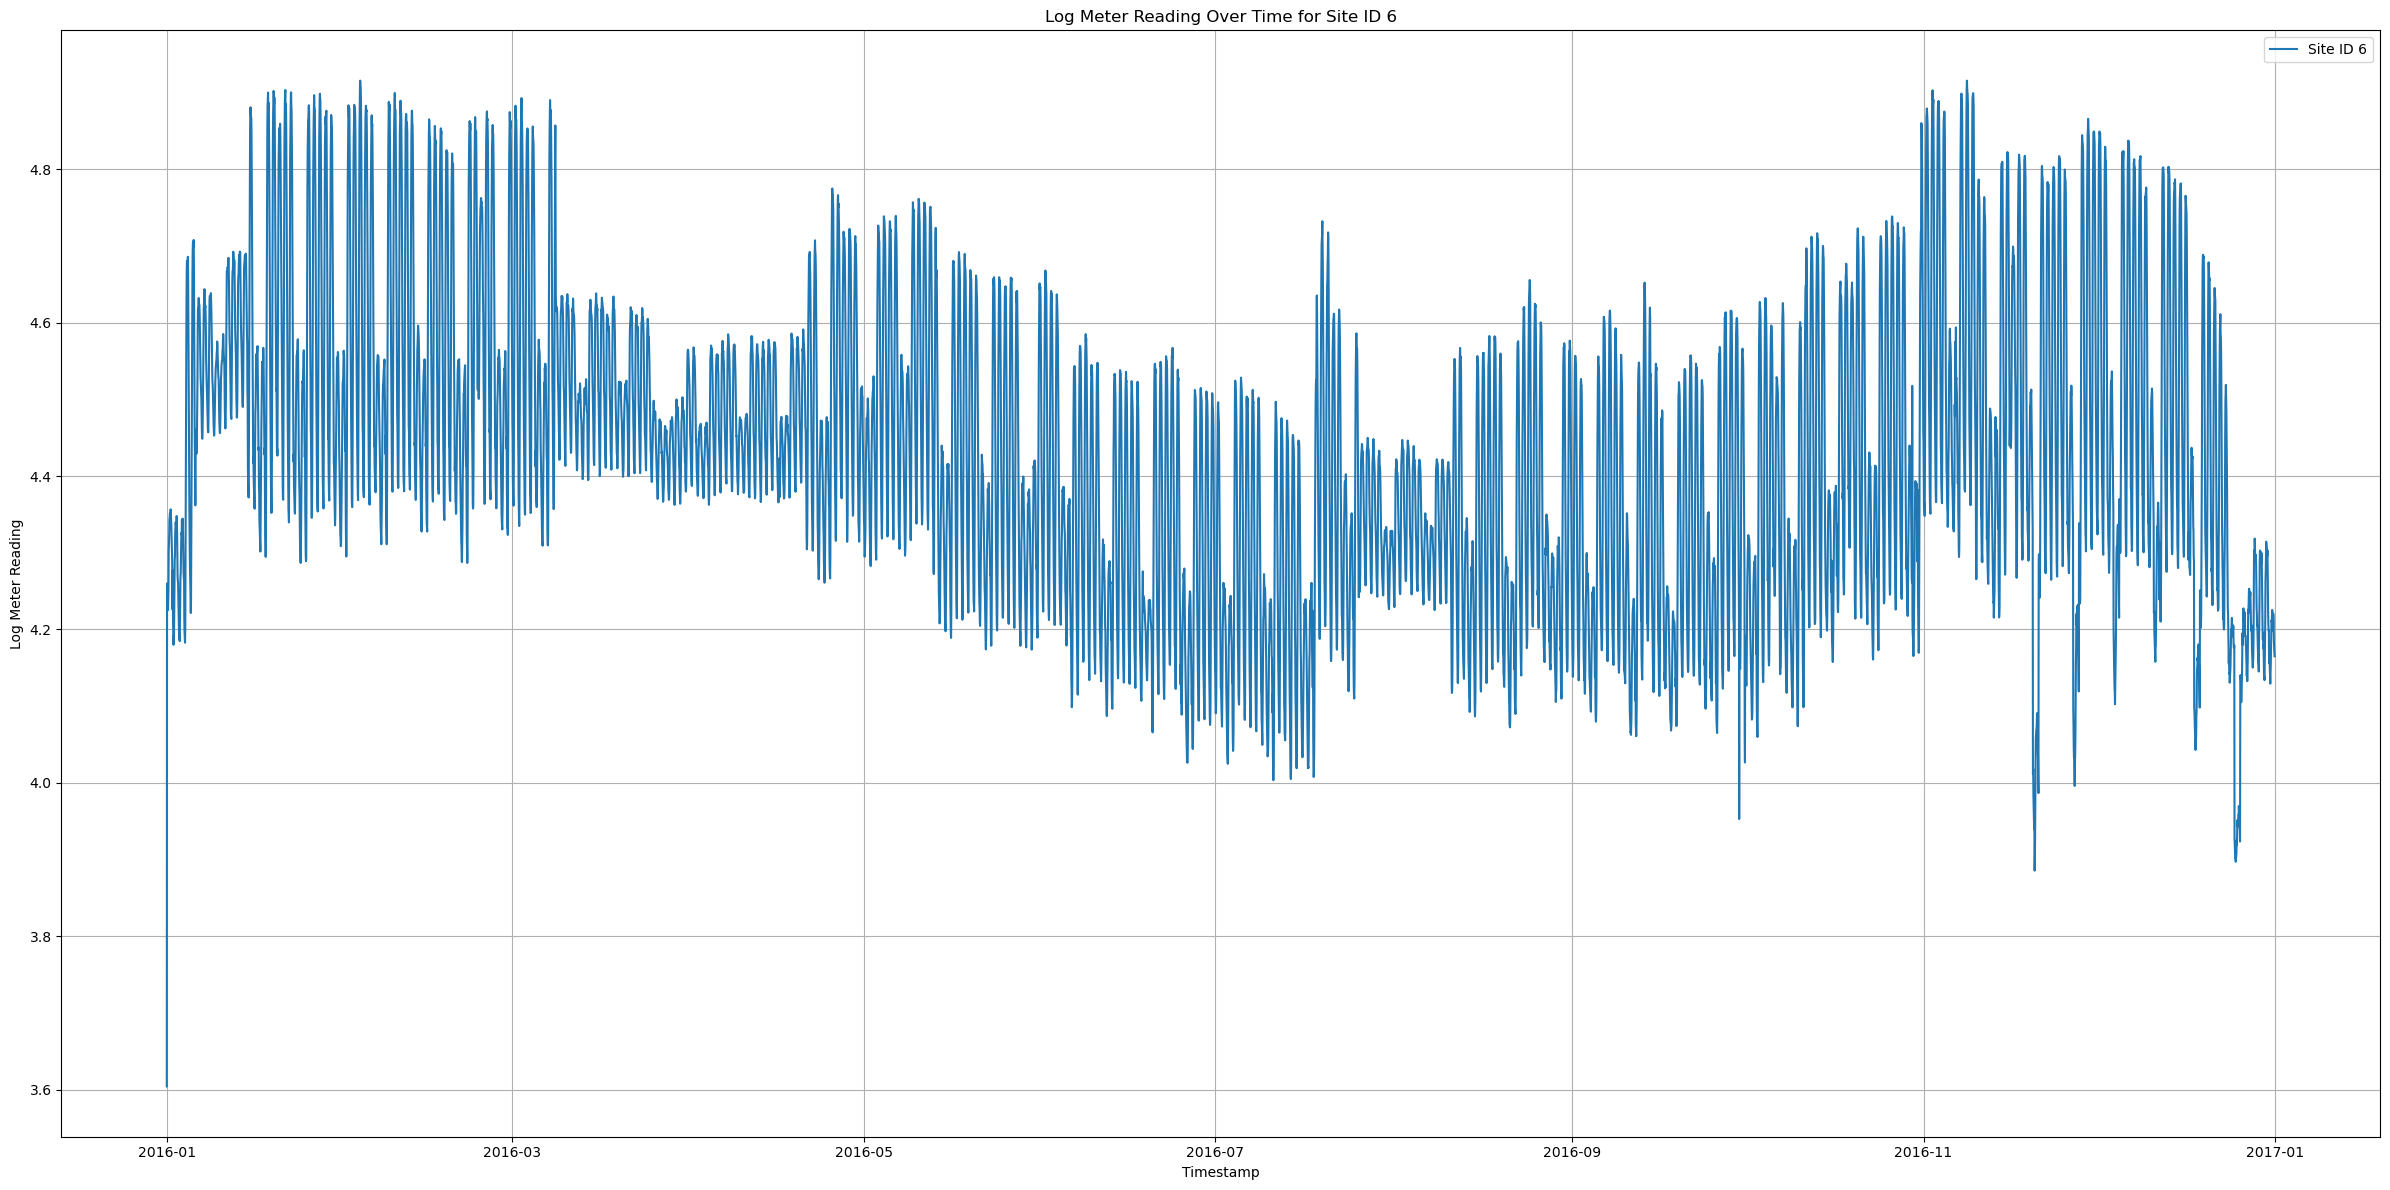

In [15]:
site_6 = df[df['site_id'] == 6]  # Changed variable name to site_1
plt.figure(figsize=(24, 12))  # Adjust the figure size as needed
plt.plot(site_1['timestamp'], site_1['log_meter_reading'], label='Site ID 6')  # Updated variable name

# Customize the plot
plt.title('Log Meter Reading Over Time for Site ID 6')
plt.xlabel('Timestamp')
plt.ylabel('Log Meter Reading')
plt.grid(True)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

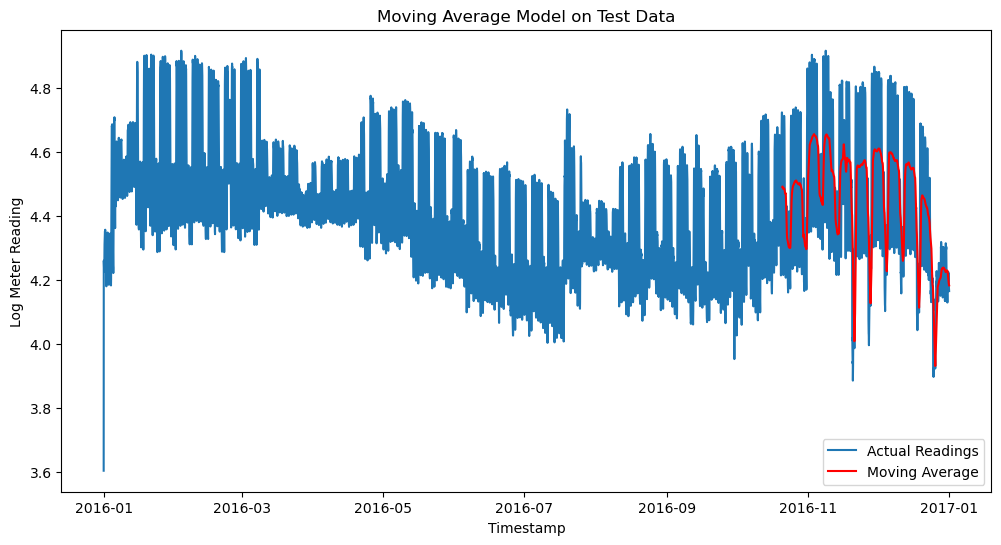

In [30]:
data = site_1.sort_values(by='timestamp')

# Using the last 20% of data as the test set
train_size = int(len(data) * 0.8)
train1_data = data[:train_size]

# Using the last 20% of data as the test set
train_size = int(len(data) * 0.8)
train1_data = data[:train_size]
test_data = data[train_size:]

# Calculating the moving average for the test data
window_size = 24  # You can adjust the window size
test_data['rolling_mean'] = test_data['log_meter_reading'].rolling(window=window_size).mean()

# Plotting the results for the test data
plt.figure(figsize=(12, 6))
plt.plot(data['timestamp'], data['log_meter_reading'], label='Actual Readings')
plt.plot(test_data['timestamp'], test_data['rolling_mean'], label='Moving Average', color='red')
plt.title('Moving Average Model on Test Data')
plt.xlabel('Timestamp')
plt.ylabel('Log Meter Reading')
plt.legend()
plt.show()